# Full Graph Construction

In [1]:
%matplotlib widget
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

# Tiling of Picture

In [2]:
# DATA
from PIL import Image
import numpy as np
i = 1
from src.datasets.MoNuSeg import MoNuSeg
from src.datasets.PanNuke import PanNuke



ds_mon = MoNuSeg(os.path.join(parent,"data","processed","MoNuSeg_TRAIN"))
sample = ds_mon[i]
img_orig,sm_gt = sample["image"].clone(),sample["semantic_mask"].clone()

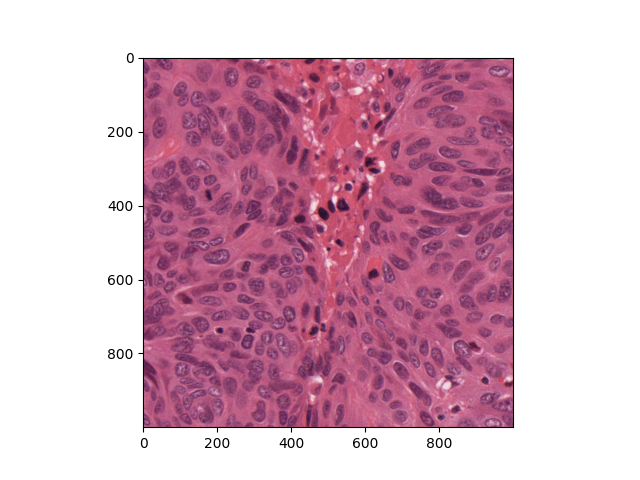

In [3]:
import matplotlib.pyplot as plt

from src.utilities.img_utilities import tensor_to_numpy

plt.imshow(tensor_to_numpy(img_orig))
plt.show()

In [4]:
# MODEL
from src.model.architectures.graph_construction.hover_net import HoVerNet
chkpt = "HoVerNet_MD-1.3.ckpt"
chkpt_path = os.path.join(parent,"experiments","checkpoints",chkpt)

model = HoVerNet.load_from_checkpoint(chkpt_path, RESNET_SIZE=50,START_LR=0)

In [5]:
import torch
from torchvision.transforms import ToTensor
from src.transforms.image_processing.augmentation import Normalize
from tqdm import tqdm


def predict_full_image(model, img,tile_size=32): # times 2, ensures that an whole number of tiles fit in the image
    model.eval()
    model.cuda()
    assert tile_size%2==0
    
    #ENSURE WHOLE NUMBER OF TILES FIT
    dim = list(img.shape[1:])
    dim[0] = dim[0]//tile_size*tile_size
    dim[1] = dim[1]//tile_size*tile_size
    img = img[:,:dim[0],:dim[1]]
    
    last_row,last_col = dim[0]-tile_size*2,dim[1]-tile_size*2
    
    final_sm = torch.zeros(img.shape[1],img.shape[2])
    final_hv_x = torch.zeros(img.shape[1],img.shape[2])
    final_hv_y = torch.zeros(img.shape[1],img.shape[2])
    
    batch_size = 20//((2*tile_size//64)*(2*tile_size//64))
    print(batch_size)
    batch = None
    batch_loc = []
    
    def add_tiles(batch,batch_loc):
        with torch.no_grad():
            (sm,hv) = model(batch.cuda())
            sm_b,hv_b = sm.cpu(),hv.cpu()
            for (r,c),sm,hv in zip(batch_loc,sm_b,hv_b):
                sm = sm.squeeze()
                assert len(sm.shape)==2
                assert len(hv.shape)==3
                mask = torch.ones_like(sm)
                if r!=0:
                    mask[:tile_size//2,:] = 0
                if r!=last_row:
                    mask[-tile_size//2:,:] = 0
                if c!=0:
                    mask[:,:tile_size//2] = 0
                if c!=last_col:
                    mask[:,-tile_size//2:] = 0
                final_sm[r:r+tile_size*2,c:c+tile_size*2] += sm*mask
                final_hv_x[r:r+tile_size*2,c:c+tile_size*2] += hv[0]*mask
                final_hv_y[r:r+tile_size*2,c:c+tile_size*2] += hv[1]*mask
        
    for row in tqdm(range(0,dim[0]-tile_size,tile_size)):
        for col in range(0,dim[1]-tile_size,tile_size):
            if batch ==None:
                batch = img[:,row:row+tile_size*2,col:col+tile_size*2].unsqueeze(0)
                batch_loc.append((row,col))
            else:
                batch = torch.concat([batch,img[:,row:row+tile_size*2,col:col+tile_size*2].unsqueeze(0)],dim=0)
                batch_loc.append((row,col))
                if batch.shape[0]>=batch_size:
                    add_tiles(batch,batch_loc)
                    del batch
                    torch.cuda.empty_cache()
                    batch= None
                    batch_loc = []
    if batch!=None:
        add_tiles(batch,batch_loc)
        del batch
        torch.cuda.empty_cache()
    return final_sm,torch.stack([final_hv_x.squeeze(0),final_hv_y.squeeze(0)],dim=0)
        
    

t_img = Normalize(
        {"image": [0.6441, 0.4474, 0.6039]},
        {"image": [0.1892, 0.1922, 0.1535]})(sample)['image']
sm,hv = predict_full_image(model,t_img)

20


 50%|█████     | 15/30 [00:11<00:09,  1.60it/s]

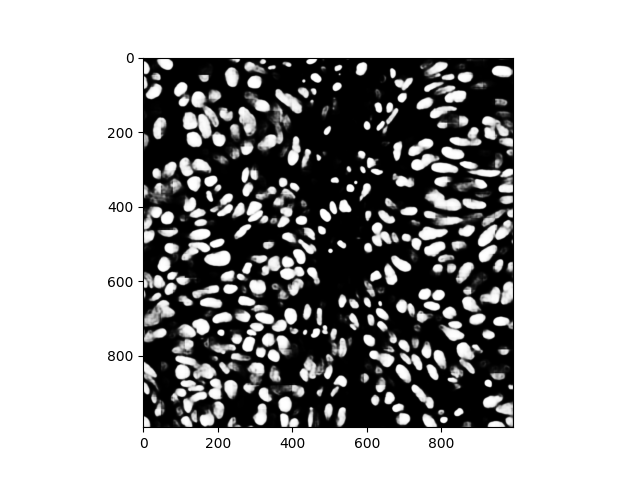

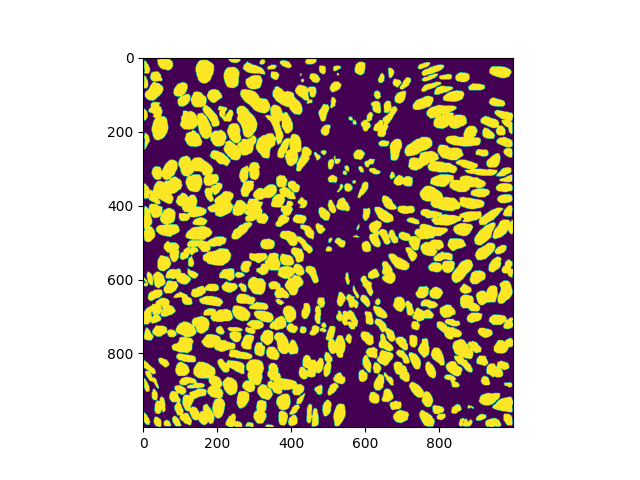

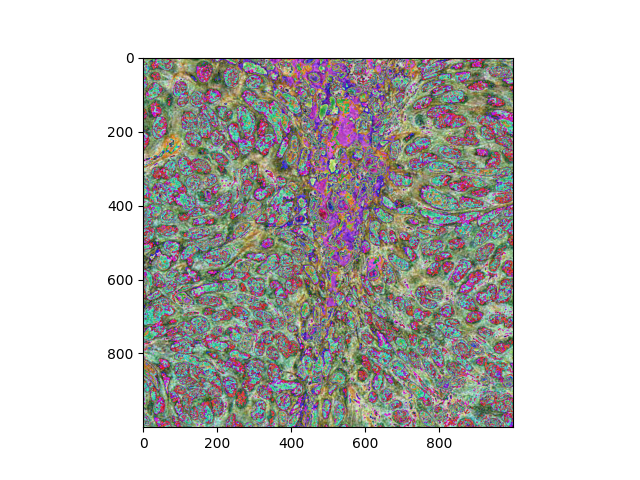

In [ ]:


plt.imshow(sm.squeeze().numpy(),cmap="gray")
plt.show()
plt.figure()
plt.imshow(sm_gt.squeeze())
plt.show()
plt.figure()
plt.imshow(tensor_to_numpy(img_orig))
plt.show()